<a href="https://colab.research.google.com/github/Shashikalayh/AllProjectsShashi/blob/main/ClassificationMLPWith3ExperimentsFV1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

#@title Environment check
import sys, torch, sklearn
print("Python:", sys.version)
print("PyTorch:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("scikit-learn:", sklearn.__version__)


Python: 3.11.13 (main, Jun  4 2025, 08:57:29) [GCC 11.4.0]
PyTorch: 2.6.0+cu124
CUDA available: False
scikit-learn: 1.6.1
Python: 3.11.13 (main, Jun  4 2025, 08:57:29) [GCC 11.4.0]
PyTorch: 2.6.0+cu124
CUDA available: False
scikit-learn: 1.6.1


In [ ]:

#@title Upload or point to your CSV
from pathlib import Path

try:
    from google.colab import files  # type: ignore
    IN_COLAB = True
except Exception:
    IN_COLAB = False

candidates = [
    Path("/content/Classification_train.csv"),
    Path("/content/classification_train.csv"),
]

DATA_PATH = next((p for p in candidates if p.exists()), None)
if IN_COLAB and DATA_PATH is None:
    print("Upload your Classification_train.csv (or classification_train.csv)")
    uploaded = files.upload()
    # pick first CSV
    chosen = None
    for k in uploaded.keys():
        if k.lower().endswith(".csv"):
            chosen = k
            break
    if chosen is None:
        chosen = next(iter(uploaded.keys()))
    DATA_PATH = Path("/content") / chosen

assert DATA_PATH is not None and DATA_PATH.exists(), "CSV not found. Upload it or place in /content."
print("Using data path:", DATA_PATH)


Using data path: /content/Classification_train.csv



# PIRvision FoG Presence Detection — PyTorch MLP Experiments (Colab)

This notebook runs **three experiments** on the PIRvision FoG dataset using a PyTorch **Multi‑Layer Perceptron (MLP)**:

**Experiment 1 — Baseline (3 hidden layers):**
- Architecture: e.g., `(256, 128, 64)` with **ReLU**
- Early stopping on validation **F1**
- Class imbalance handled via **`pos_weight`**

**Experiment 2 — Impact of Neurons per Layer (fix 3 hidden layers):**
- Compare different hidden sizes: `(64, 32, 16)`, `(128, 64, 32)`, `(256, 128, 64)`
- Observe **training time** and **performance**

**Experiment 3 — Activation Functions (fix hidden sizes):**
- Compare **ReLU**, **Tanh**, **Sigmoid** (for hidden layers)
- Observe how activation affects optimization and accuracy/F1

**Expected CSV:** `Classification_train.csv` (or `classification_train.csv`) with columns including `Date`, `Time` (optional), numeric features, and a binary **`Label`** (0/1).  
The notebook drops `Date`/`Time` (if present), standardizes features, and splits data (70/15/15).

_Generated: 2025-08-11 17:48_


In [ ]:

#@title Load & preprocess
import pandas as pd

df = pd.read_csv(DATA_PATH)

# Drop Date/Time if present (case-insensitive)
lower_map = {c.lower(): c for c in df.columns}
for key in ("date", "time"):
    if key in lower_map:
        df = df.drop(columns=[lower_map[key]])

# Ensure Label exists (case-insensitive)
label_col = None
for c in df.columns:
    if c.lower() == "label":
        label_col = c
        break
assert label_col is not None, "Expected a binary 'Label' column (0/1)."

X = df.drop(columns=[label_col]).apply(pd.to_numeric, errors="coerce")
X = X.fillna(X.median(numeric_only=True))  # fill missing numeric values
y = df[label_col].astype(int)

print("Columns:", list(df.columns))
print("Shape:", df.shape)
print("Class counts:\n", y.value_counts())


Columns: ['Label', 'Temperature_F', 'PIR_1', 'PIR_2', 'PIR_3', 'PIR_4', 'PIR_5', 'PIR_6', 'PIR_7', 'PIR_8', 'PIR_9', 'PIR_10', 'PIR_11', 'PIR_12', 'PIR_13', 'PIR_14', 'PIR_15', 'PIR_16', 'PIR_17', 'PIR_18', 'PIR_19', 'PIR_20', 'PIR_21', 'PIR_22', 'PIR_23', 'PIR_24', 'PIR_25', 'PIR_26', 'PIR_27', 'PIR_28', 'PIR_29', 'PIR_30', 'PIR_31', 'PIR_32', 'PIR_33', 'PIR_34', 'PIR_35', 'PIR_36', 'PIR_37', 'PIR_38', 'PIR_39', 'PIR_40', 'PIR_41', 'PIR_42', 'PIR_43', 'PIR_44', 'PIR_45', 'PIR_46', 'PIR_47', 'PIR_48', 'PIR_49', 'PIR_50', 'PIR_51', 'PIR_52', 'PIR_53', 'PIR_54', 'PIR_55']
Shape: (7651, 57)
Class counts:
 Label
0    6247
1     833
3     571
Name: count, dtype: int64


In [ ]:

#@title Split & scale
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Keep splits fixed for fair comparison
RANDOM_STATE = 42

# Stratified split: 70/15/15
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, random_state=RANDOM_STATE, stratify=y
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=RANDOM_STATE, stratify=y_temp
)

scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_val_s   = scaler.transform(X_val)
X_test_s  = scaler.transform(X_test)

print("Train/Val/Test sizes:", X_train.shape[0], X_val.shape[0], X_test.shape[0])
print("Feature count:", X_train.shape[1])


Train/Val/Test sizes: 5355 1148 1148
Feature count: 56


In [ ]:

#@title Torch Dataset & DataLoaders
import torch
from torch.utils.data import Dataset, DataLoader

class TabularDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y.values if hasattr(y, "values") else y, dtype=torch.float32)
    def __len__(self): return len(self.X)
    def __getitem__(self, idx): return self.X[idx], self.y[idx]

BATCH_SIZE = 256

train_loader = DataLoader(TabularDataset(X_train_s, y_train), batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(TabularDataset(X_val_s,   y_val),   batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(TabularDataset(X_test_s,  y_test),  batch_size=BATCH_SIZE, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cpu')

In [ ]:

#@title MLP factory (configurable hidden sizes + activation)
import torch.nn as nn

def get_activation(name: str):
    name = name.lower()
    if name == "relu":
        return nn.ReLU()
    if name == "tanh":
        return nn.Tanh()
    if name == "sigmoid":
        return nn.Sigmoid()
    raise ValueError(f"Unsupported activation: {name}")

class MLP(nn.Module):
    def __init__(self, in_features, hidden_sizes=(256,128,64), activation="relu", p=0.2):
        super().__init__()
        act = get_activation(activation)
        layers = []
        prev = in_features
        for h in hidden_sizes:
            layers += [nn.Linear(prev, h), nn.BatchNorm1d(h), act, nn.Dropout(p)]
            prev = h
        layers += [nn.Linear(prev, 1)]  # binary logit
        self.net = nn.Sequential(*layers)
    def forward(self, x):
        return self.net(x).squeeze(1)


In [ ]:
#@title Training & evaluation helpers
import time, numpy as np
from collections import Counter
import torch
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

def compute_pos_weight(y_series):
    cnt = Counter(y_series.tolist())
    neg, pos = cnt.get(0, 0), cnt.get(1, 0)
    return neg / max(pos, 1), (neg, pos)

def evaluate(model, loader, device):
    model.eval()
    ys, ps = [], []
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            prob = torch.sigmoid(model(xb))
            ys.append(yb.cpu().numpy())
            ps.append(prob.cpu().numpy())
    y_true = np.concatenate(ys)
    y_prob = np.concatenate(ps)
    y_pred = (y_prob >= 0.5).astype(int)
    metrics = {
        "acc":  accuracy_score(y_true, y_pred),
        "prec": precision_score(y_true, y_pred, average='weighted', zero_division=0),
        "rec":  recall_score(y_true, y_pred, average='weighted', zero_division=0),
        "f1":   f1_score(y_true, y_pred, average='weighted', zero_division=0),
        "auc":  roc_auc_score(y_true, y_prob) if len(np.unique(y_true)) == 2 else float("nan"),
    }
    return metrics, y_true, y_pred, y_prob

def train_one_config(in_features, train_loader, val_loader, device,
                     hidden_sizes=(256,128,64), activation="relu",
                     epochs=150, patience=20, lr=1e-3, wd=1e-4, dropout=0.2, save_tag=None):
    model = MLP(in_features=in_features, hidden_sizes=hidden_sizes, activation=activation, p=dropout).to(device)
    pos_weight_val, (neg, pos) = compute_pos_weight(y_train) # Assuming y_train is accessible
    pos_weight = torch.tensor([pos_weight_val], dtype=torch.float32, device=device)

    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=wd)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="max", factor=0.5, patience=5, verbose=False)

    best_f1, best_state, wait = -1.0, None, 0
    hist_loss, hist_f1 = [], []

    t0 = time.time()
    for epoch in range(1, epochs + 1):
        model.train()
        run_loss, n_batches = 0.0, 0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            logits = model(xb)
            loss = criterion(logits, yb)
            loss.backward()
            optimizer.step()
            run_loss += float(loss.item())
            n_batches += 1

        train_loss = run_loss / max(n_batches, 1)
        val_metrics, _, _, _ = evaluate(model, val_loader, device)
        hist_loss.append(train_loss); hist_f1.append(val_metrics["f1"])
        scheduler.step(val_metrics["f1"])

        if val_metrics["f1"] > best_f1:
            best_f1 = val_metrics["f1"]
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
            wait = 0
        else:
            wait += 1
            if wait >= patience:
                break

    if best_state is not None:
        model.load_state_dict(best_state)
    train_time = time.time() - t0

    test_metrics, y_true, y_pred, y_prob = evaluate(model, test_loader, device) # Assuming test_loader is accessible

    # Optionally save best model
    if save_tag is not None:
        path = f"/content/mlp_{save_tag}.pth"
        try:
            torch.save(model.state_dict(), path)
            saved_to = path
        except Exception as e:
            saved_to = f"save failed: {e}"
    else:
        saved_to = ""

    return {
        "hidden_sizes": str(tuple(hidden_sizes)),
        "activation": activation,
        "epochs": epochs,
        "lr": lr,
        "weight_decay": wd,
        "dropout": dropout,
        "train_time_sec": round(train_time, 2),
        "val_best_f1": round(best_f1, 4),
        "test_acc": round(test_metrics["acc"], 4),
        "test_prec": round(test_metrics["prec"], 4),
        "test_rec": round(test_metrics["rec"], 4),
        "test_f1": round(test_metrics["f1"], 4),
        "test_auc": round(test_metrics["auc"], 4) if test_metrics["auc"] == test_metrics["auc"] else "nan",
        "saved_model": saved_to,
        "class_counts_train": f"0={neg}, 1={pos}",
        "y_true": y_true,  # Return true labels
        "y_pred": y_pred,  # Return predicted labels
        "model_config": {"hidden_sizes": hidden_sizes, "activation": activation, "p": dropout} # Return model configuration
    }, hist_loss, hist_f1

In [ ]:
#@title Experiment 1 — Baseline (3 hidden layers, ReLU)
HIDDEN_BASE = (256, 128, 64)
res1, hist_loss1, hist_f11 = train_one_config(in_features=X_train_s.shape[1], hidden_sizes=HIDDEN_BASE, activation="relu",
                                              epochs=150, patience=20, save_tag="exp1_baseline",
                                              train_loader=train_loader, val_loader=val_loader, device=device)
print(res1)

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


{'hidden_sizes': '(256, 128, 64)', 'activation': 'relu', 'epochs': 150, 'lr': 0.001, 'weight_decay': 0.0001, 'dropout': 0.2, 'train_time_sec': 5.73, 'val_best_f1': 0.8912, 'test_acc': 0.9146, 'test_prec': 0.8765, 'test_rec': 0.9146, 'test_f1': 0.8892, 'test_auc': 'nan', 'saved_model': '/content/mlp_exp1_baseline.pth', 'class_counts_train': '0=4372, 1=583', 'y_true': array([0., 0., 0., ..., 0., 3., 0.], dtype=float32), 'y_pred': array([0, 0, 0, ..., 0, 1, 0]), 'model_config': {'hidden_sizes': (256, 128, 64), 'activation': 'relu', 'p': 0.2}}


In [ ]:
#@title Experiment 2 — Impact of Neurons per Layer (3 layers fixed)
sizes_list = [
    (64, 32, 16),
    (128, 64, 32),
    (256, 128, 64),
]
exp2_results = []
exp2_histories = []
exp2_preds = []
for sz in sizes_list:
    tag = f"exp2_{sz[0]}_{sz[1]}_{sz[2]}"
    res, hist_loss, hist_f1 = train_one_config(in_features=X_train_s.shape[1], hidden_sizes=sz, activation="relu",
                                 epochs=150, patience=20, save_tag=tag,
                                 train_loader=train_loader, val_loader=val_loader, device=device)
    exp2_results.append(res)
    exp2_histories.append((hist_loss, hist_f1, tag))
    exp2_preds.append((res["y_true"], res["y_pred"], tag))
    print(res)

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


{'hidden_sizes': '(64, 32, 16)', 'activation': 'relu', 'epochs': 150, 'lr': 0.001, 'weight_decay': 0.0001, 'dropout': 0.2, 'train_time_sec': 6.96, 'val_best_f1': 0.8773, 'test_acc': 0.8972, 'test_prec': 0.8731, 'test_rec': 0.8972, 'test_f1': 0.8764, 'test_auc': 'nan', 'saved_model': '/content/mlp_exp2_64_32_16.pth', 'class_counts_train': '0=4372, 1=583', 'y_true': array([0., 0., 0., ..., 0., 3., 0.], dtype=float32), 'y_pred': array([0, 0, 0, ..., 0, 1, 0]), 'model_config': {'hidden_sizes': (64, 32, 16), 'activation': 'relu', 'p': 0.2}}


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


{'hidden_sizes': '(128, 64, 32)', 'activation': 'relu', 'epochs': 150, 'lr': 0.001, 'weight_decay': 0.0001, 'dropout': 0.2, 'train_time_sec': 9.52, 'val_best_f1': 0.8852, 'test_acc': 0.9077, 'test_prec': 0.8743, 'test_rec': 0.9077, 'test_f1': 0.8839, 'test_auc': 'nan', 'saved_model': '/content/mlp_exp2_128_64_32.pth', 'class_counts_train': '0=4372, 1=583', 'y_true': array([0., 0., 0., ..., 0., 3., 0.], dtype=float32), 'y_pred': array([0, 0, 0, ..., 0, 1, 0]), 'model_config': {'hidden_sizes': (128, 64, 32), 'activation': 'relu', 'p': 0.2}}


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


{'hidden_sizes': '(256, 128, 64)', 'activation': 'relu', 'epochs': 150, 'lr': 0.001, 'weight_decay': 0.0001, 'dropout': 0.2, 'train_time_sec': 8.98, 'val_best_f1': 0.8903, 'test_acc': 0.9146, 'test_prec': 0.8765, 'test_rec': 0.9146, 'test_f1': 0.8892, 'test_auc': 'nan', 'saved_model': '/content/mlp_exp2_256_128_64.pth', 'class_counts_train': '0=4372, 1=583', 'y_true': array([0., 0., 0., ..., 0., 3., 0.], dtype=float32), 'y_pred': array([0, 0, 0, ..., 0, 1, 0]), 'model_config': {'hidden_sizes': (256, 128, 64), 'activation': 'relu', 'p': 0.2}}


In [ ]:
#@title Experiment 3 — Activation Functions (sizes fixed)
ACT_SIZES = (128, 64, 32)  # fixed sizes for fair activation comparison
activations = ["relu", "tanh", "sigmoid"]
exp3_results = []
exp3_histories = []
exp3_preds = []
for act in activations:
    tag = f"exp3_{act}"
    res, hist_loss, hist_f1 = train_one_config(in_features=X_train_s.shape[1], hidden_sizes=ACT_SIZES, activation=act,
                                 epochs=150, patience=20, save_tag=tag,
                                 train_loader=train_loader, val_loader=val_loader, device=device)
    exp3_results.append(res)
    exp3_histories.append((hist_loss, hist_f1, tag))
    exp3_preds.append((res["y_true"], res["y_pred"], tag))
    print(res)

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


{'hidden_sizes': '(128, 64, 32)', 'activation': 'relu', 'epochs': 150, 'lr': 0.001, 'weight_decay': 0.0001, 'dropout': 0.2, 'train_time_sec': 7.37, 'val_best_f1': 0.8858, 'test_acc': 0.9085, 'test_prec': 0.8754, 'test_rec': 0.9085, 'test_f1': 0.8848, 'test_auc': 'nan', 'saved_model': '/content/mlp_exp3_relu.pth', 'class_counts_train': '0=4372, 1=583', 'y_true': array([0., 0., 0., ..., 0., 3., 0.], dtype=float32), 'y_pred': array([0, 0, 0, ..., 0, 1, 0]), 'model_config': {'hidden_sizes': (128, 64, 32), 'activation': 'relu', 'p': 0.2}}


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


{'hidden_sizes': '(128, 64, 32)', 'activation': 'tanh', 'epochs': 150, 'lr': 0.001, 'weight_decay': 0.0001, 'dropout': 0.2, 'train_time_sec': 10.0, 'val_best_f1': 0.8918, 'test_acc': 0.9181, 'test_prec': 0.8784, 'test_rec': 0.9181, 'test_f1': 0.8921, 'test_auc': 'nan', 'saved_model': '/content/mlp_exp3_tanh.pth', 'class_counts_train': '0=4372, 1=583', 'y_true': array([0., 0., 0., ..., 0., 3., 0.], dtype=float32), 'y_pred': array([0, 0, 0, ..., 0, 1, 0]), 'model_config': {'hidden_sizes': (128, 64, 32), 'activation': 'tanh', 'p': 0.2}}


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


{'hidden_sizes': '(128, 64, 32)', 'activation': 'sigmoid', 'epochs': 150, 'lr': 0.001, 'weight_decay': 0.0001, 'dropout': 0.2, 'train_time_sec': 12.72, 'val_best_f1': 0.8804, 'test_acc': 0.9024, 'test_prec': 0.8736, 'test_rec': 0.9024, 'test_f1': 0.8802, 'test_auc': 'nan', 'saved_model': '/content/mlp_exp3_sigmoid.pth', 'class_counts_train': '0=4372, 1=583', 'y_true': array([0., 0., 0., ..., 0., 3., 0.], dtype=float32), 'y_pred': array([0, 0, 0, ..., 0, 1, 0]), 'model_config': {'hidden_sizes': (128, 64, 32), 'activation': 'sigmoid', 'p': 0.2}}


=== All Experiment Results (sorted by test F1) ===
                  experiment    hidden_sizes activation  epochs     lr  \
0              exp3_act_tanh   (128, 64, 32)       tanh     150  0.001   
1  exp2_sizes_(256, 128, 64)  (256, 128, 64)       relu     150  0.001   
2              exp1_baseline  (256, 128, 64)       relu     150  0.001   
3              exp3_act_relu   (128, 64, 32)       relu     150  0.001   
4   exp2_sizes_(128, 64, 32)   (128, 64, 32)       relu     150  0.001   
5           exp3_act_sigmoid   (128, 64, 32)    sigmoid     150  0.001   
6    exp2_sizes_(64, 32, 16)    (64, 32, 16)       relu     150  0.001   

   weight_decay  dropout  train_time_sec  val_best_f1  test_acc  test_prec  \
0        0.0001      0.2           10.00       0.8918    0.9181     0.8784   
1        0.0001      0.2            8.98       0.8903    0.9146     0.8765   
2        0.0001      0.2            5.73       0.8912    0.9146     0.8765   
3        0.0001      0.2            7.37    

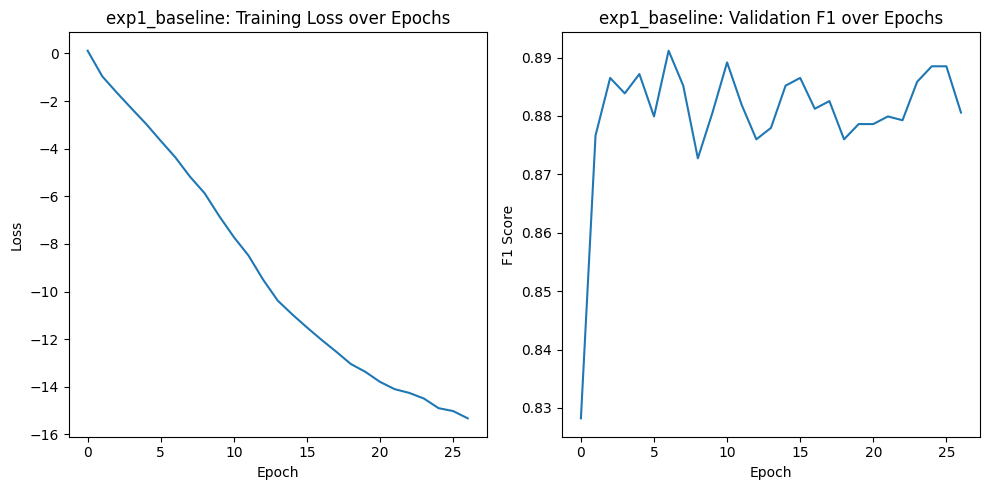

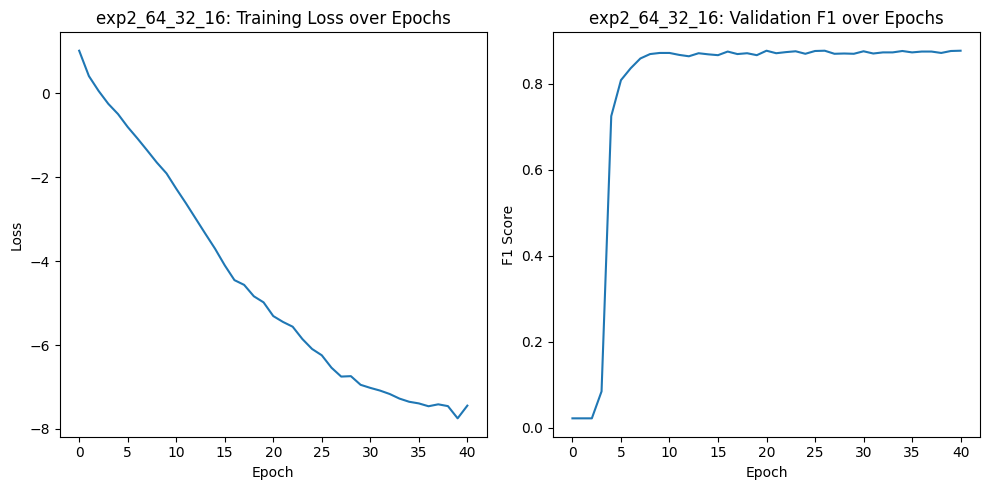

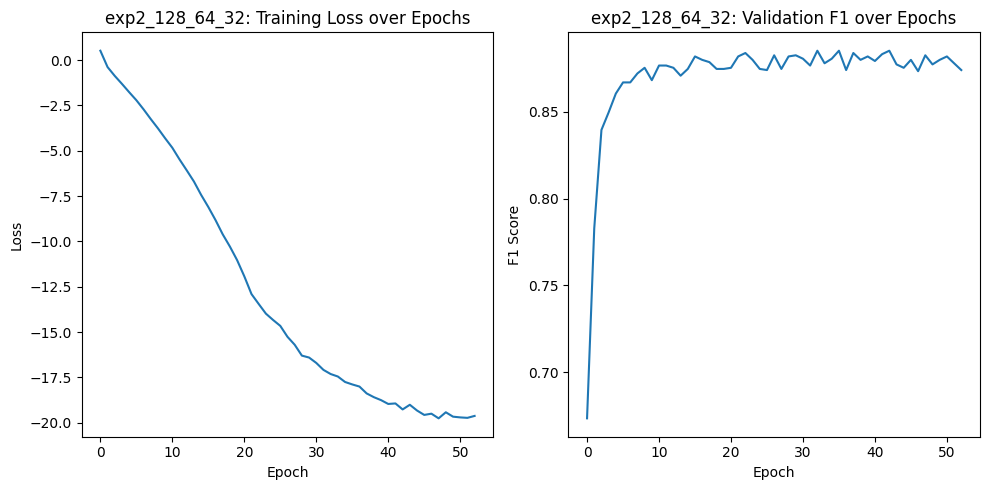

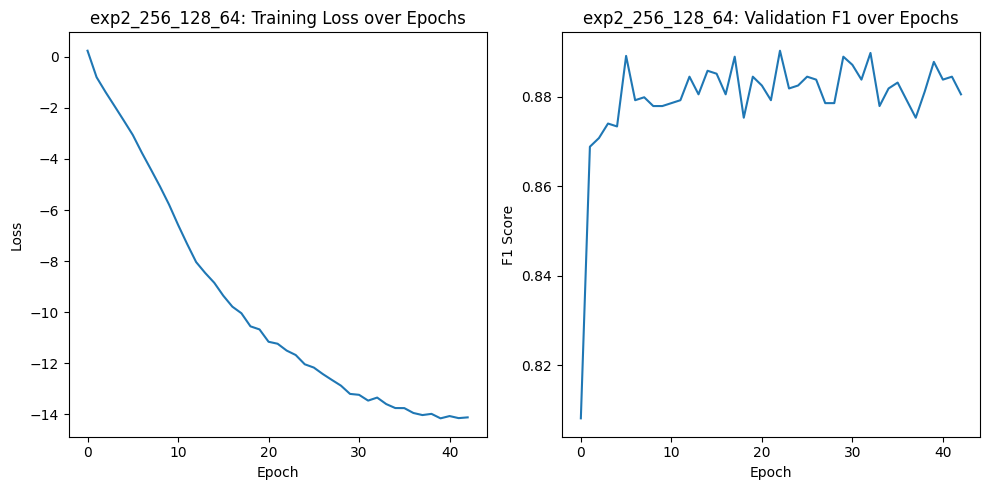

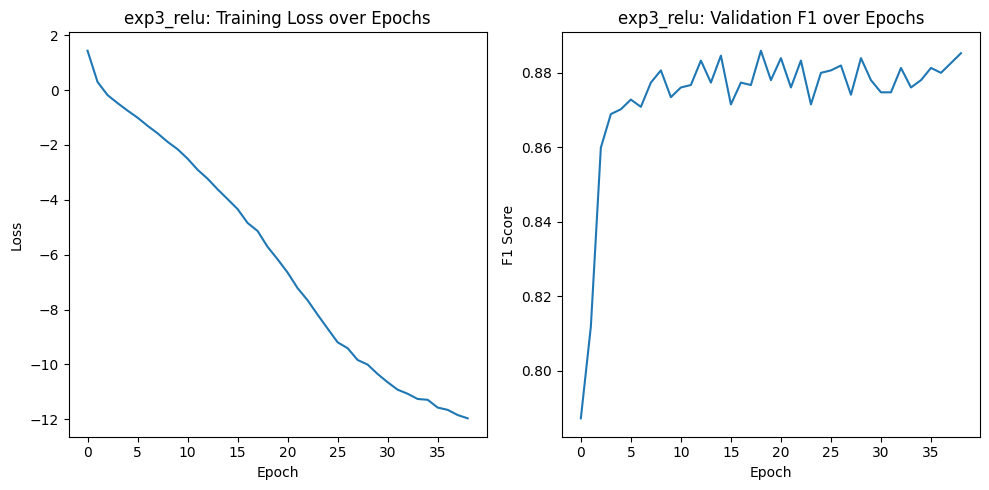

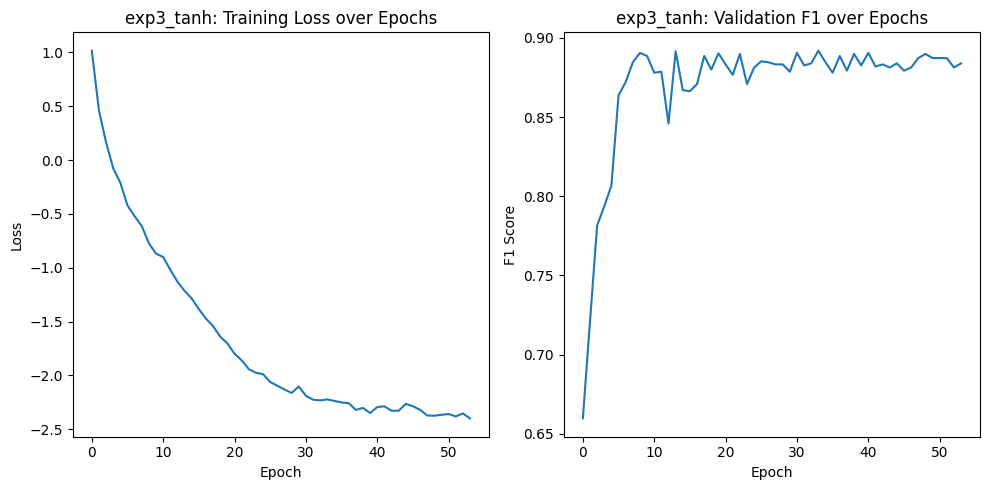

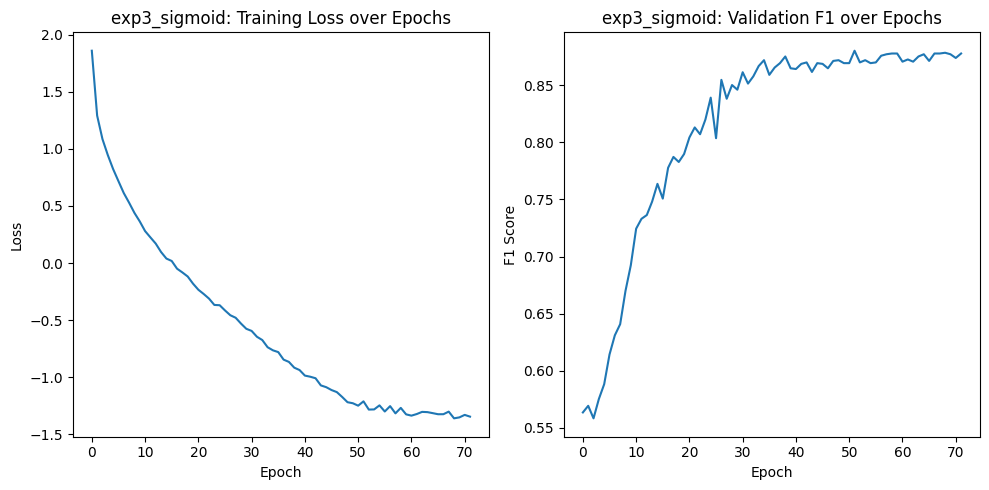

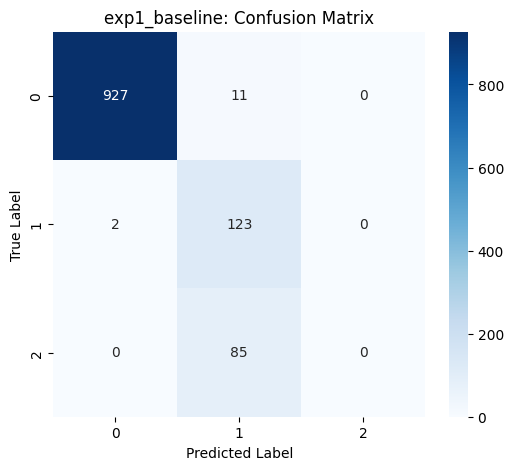

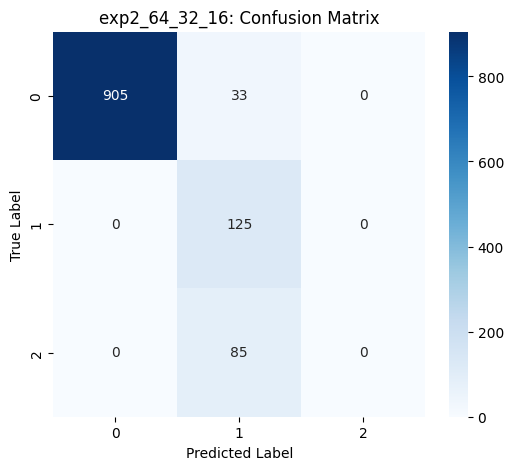

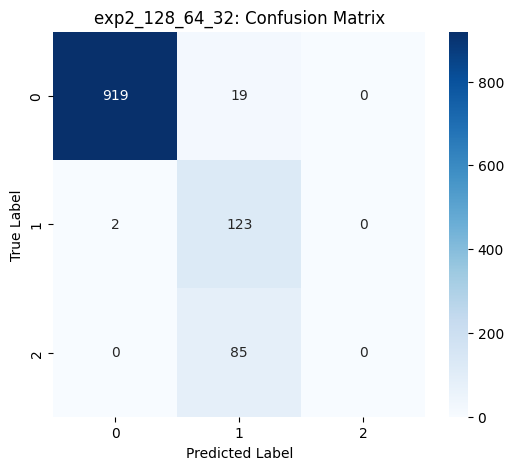

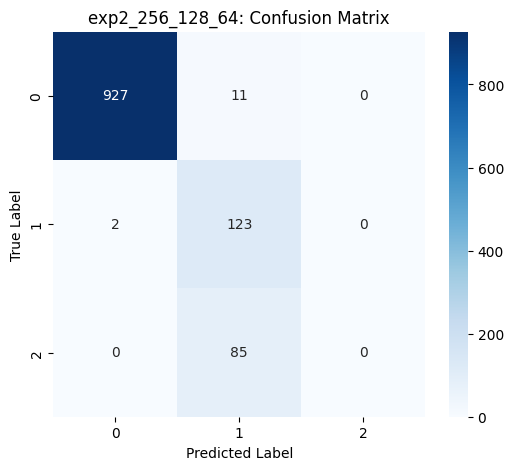

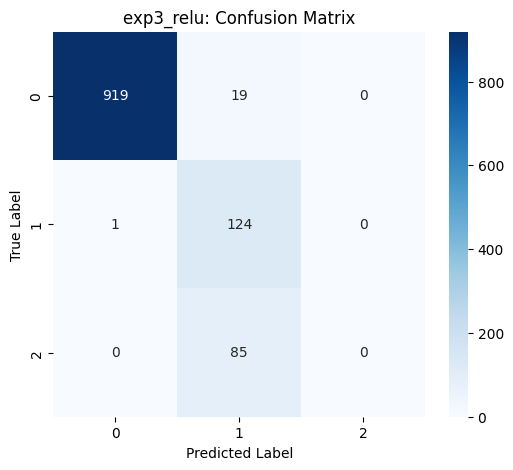

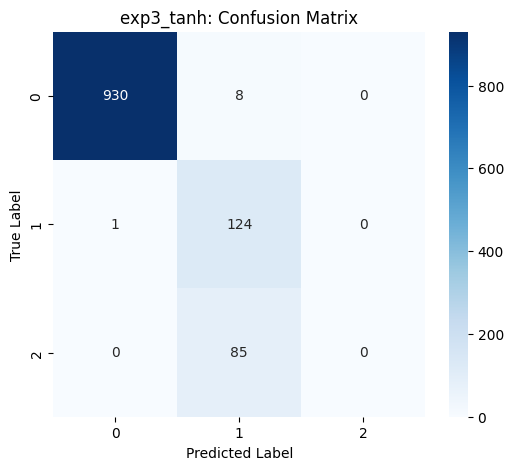

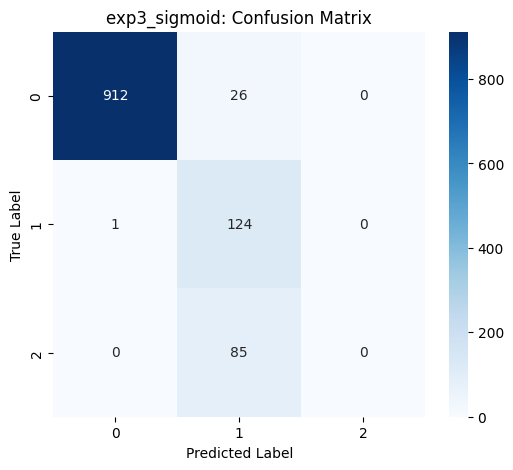

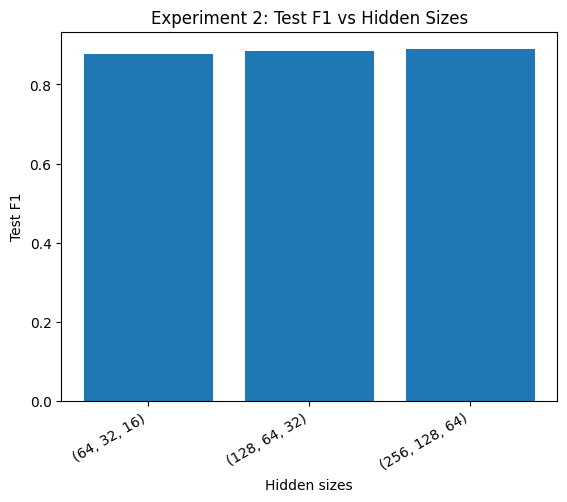

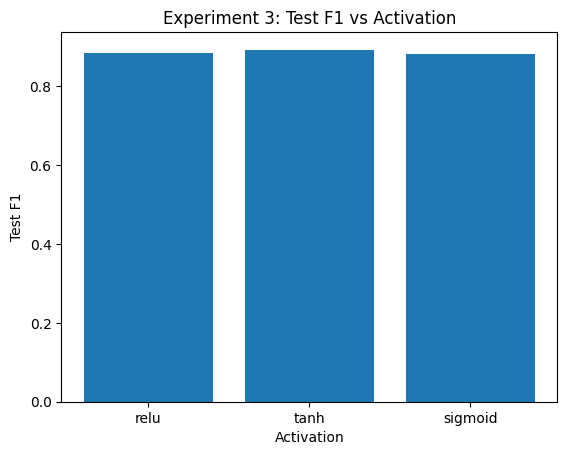

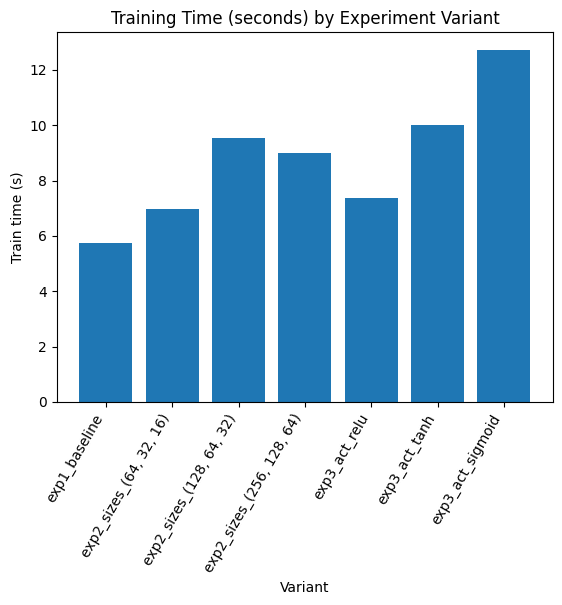

In [ ]:
#@title Summaries & plots
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Collect rows
rows = []
rows.append({"experiment": "exp1_baseline", **res1})
for r in exp2_results:
    rows.append({"experiment": f"exp2_sizes_{r['hidden_sizes']}", **r})
for r in exp3_results:
    rows.append({"experiment": f"exp3_act_{r['activation']}", **r})

df_results = pd.DataFrame(rows)
df_results_sorted = df_results.sort_values(by=["test_f1"], ascending=False)
print("=== All Experiment Results (sorted by test F1) ===")
print(df_results_sorted.reset_index(drop=True))

# Save results
csv_path = "/content/experiment_results.csv"
df_results_sorted.to_csv(csv_path, index=False)
print("Saved results to:", csv_path)

# Print classification metrics and report for all experiments
all_preds = [(res1["y_true"], res1["y_pred"], "exp1_baseline")] + exp2_preds + exp3_preds

for y_true, y_pred, tag in all_preds:
    print(f"\n=== Classification Metrics and Report for {tag} ===")
    print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
    print(f"Precision: {precision_score(y_true, y_pred, average='weighted', zero_division=0):.4f}")
    print(f"Recall: {recall_score(y_true, y_pred, average='weighted', zero_division=0):.4f}")
    print(f"F1 Score: {f1_score(y_true, y_pred, average='weighted', zero_division=0):.4f}")
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, zero_division=0))


# Plot histories for all experiments
all_histories = [(hist_loss1, hist_f11, "exp1_baseline")] + exp2_histories + exp3_histories

for hist_loss, hist_f1, tag in all_histories:
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(hist_loss)
    plt.title(f"{tag}: Training Loss over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")

    plt.subplot(1, 2, 2)
    plt.plot(hist_f1)
    plt.title(f"{tag}: Validation F1 over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("F1 Score")
    plt.tight_layout()
    plt.show()

# Plot confusion matrix heatmaps for all experiments
for y_true, y_pred, tag in all_preds:
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"{tag}: Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()


# Plot: Experiment 2 — F1 by size
df_exp2 = df_results[df_results["experiment"].str.startswith("exp2_sizes_")].copy()
plt.figure()
plt.bar(df_exp2["hidden_sizes"], df_exp2["test_f1"])
plt.title("Experiment 2: Test F1 vs Hidden Sizes")
plt.xlabel("Hidden sizes")
plt.ylabel("Test F1")
plt.xticks(rotation=30, ha="right")
plt.show()

# Plot: Experiment 3 — F1 by activation
df_exp3 = df_results[df_results["experiment"].str.startswith("exp3_act_")].copy()
plt.figure()
plt.bar(df_exp3["activation"], df_exp3["test_f1"])
plt.title("Experiment 3: Test F1 vs Activation")
plt.xlabel("Activation")
plt.ylabel("Test F1")
plt.show()

# Plot: Training time comparison (all runs)
plt.figure()
plt.bar(df_results["experiment"], df_results["train_time_sec"])
plt.title("Training Time (seconds) by Experiment Variant")
plt.xlabel("Variant")
plt.ylabel("Train time (s)")
plt.xticks(rotation=60, ha="right")
plt.show()


## Discussion Prompts

- **Experiment 2 (Neurons per Layer):** Larger layers generally increase representation power but can lead to longer training time and potential overfitting. Compare Test F1 with training time across `(64,32,16)`, `(128,64,32)`, `(256,128,64)`.
- **Experiment 3 (Activation):** ReLU usually accelerates convergence and mitigates vanishing gradients; `tanh` can work well but may converge slower; `sigmoid` often struggles in deeper nets due to saturation. Compare both **F1** and **AUC**.
- Consider trying **Dropout** or **Weight Decay** sweeps, and varying **learning rates** for further analysis.


In [ ]:
import torch
import pandas as pd
from sklearn.preprocessing import StandardScaler # Import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Assuming the StandardScaler object 'scaler' is still available from the previous run.
# If not, you would need to save and load it as well.

def test_model_with_live_data(model_path: str, live_data_path: str, scaler: StandardScaler, device: torch.device, model_config: dict):
    """
    Tests a trained MLP model with live data.

    Args:
        model_path: Path to the saved model's state_dict (.pth file).
        live_data_path: Path to the live data CSV file.
        scaler: Fitted StandardScaler object used during training.
        device: The device to run the model on (e.g., 'cuda' or 'cpu').
        model_config: Dictionary containing the model configuration (hidden_sizes, activation, p).
    """
    # Load the trained model
    in_features = scaler.n_features_in_ # Get the number of input features from the scaler
    model = MLP(in_features=in_features, **model_config) # Initialize model with provided config
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()

    # Load and preprocess the live data
    live_df = pd.read_csv(live_data_path)

    # Drop Date/Time if present (case-insensitive)
    lower_map = {c.lower(): c for c in live_df.columns}
    for key in ("date", "time"):
        if key in lower_map:
            live_df = live_df.drop(columns=[lower_map[key]])

    # Ensure Label exists (case-insensitive)
    label_col = None
    for c in live_df.columns:
        if c.lower() == "label":
            label_col = c
            break
    assert label_col is not None, "Expected a binary 'Label' column (0/1)."

    X_live = live_df.drop(columns=[label_col]).apply(pd.to_numeric, errors="coerce")
    X_live = X_live.fillna(X_live.median(numeric_only=True))  # fill missing numeric values
    y_live = live_df[label_col].astype(int)

    # Scale the live data using the fitted scaler
    X_live_s = scaler.transform(X_live)

    # Create DataLoader for live data
    live_dataset = TabularDataset(X_live_s, y_live)
    live_loader = DataLoader(live_dataset, batch_size=BATCH_SIZE, shuffle=False)

    # Evaluate the model on live data
    metrics, y_true, y_pred, y_prob = evaluate(model, live_loader, device)

    print("\n=== Live Data Evaluation Metrics ===")
    print(f"Accuracy: {metrics['acc']:.4f}")
    print(f"Precision: {metrics['prec']:.4f}")
    print(f"Recall: {metrics['rec']:.4f}")
    print(f"F1 Score: {metrics['f1']:.4f}")
    if not np.isnan(metrics['auc']):
      print(f"AUC: {metrics['auc']:.4f}")
    else:
      print("AUC: nan")

    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, zero_division=0))

    # Plot confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title("Live Data Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

Now you can call the `test_model_with_live_data` function with the path to your saved model, the path to your live data CSV, and the `scaler` object that was fitted during the training process.

For example, to test the baseline model (`exp1_baseline`) with a live data file named `test_classification.csv` (assuming it's in the /content directory), you would use:


Testing model: /content/mlp_exp1_baseline.pth with config {'hidden_sizes': (256, 128, 64), 'activation': 'relu', 'p': 0.2}

=== Live Data Evaluation Metrics ===
Accuracy: 0.9148
Precision: 0.8757
Recall: 0.9148
F1 Score: 0.8890
AUC: nan

Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99      6247
         1.0       0.56      0.98      0.72       833
         3.0       0.00      0.00      0.00       571

    accuracy                           0.91      7651
   macro avg       0.52      0.66      0.57      7651
weighted avg       0.88      0.91      0.89      7651



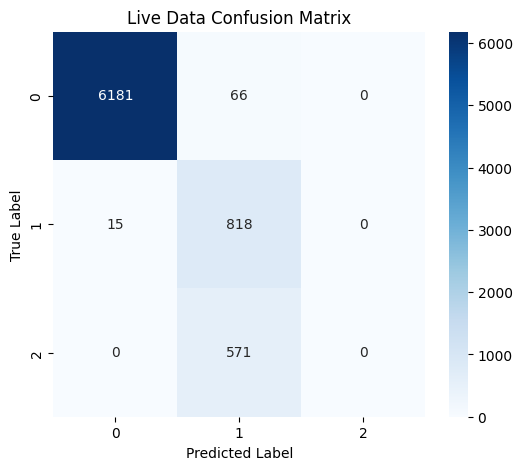


Testing model: /content/mlp_exp2_64_32_16.pth with config {'hidden_sizes': (64, 32, 16), 'activation': 'relu', 'p': 0.2}

=== Live Data Evaluation Metrics ===
Accuracy: 0.9020
Precision: 0.8734
Recall: 0.9020
F1 Score: 0.8796
AUC: nan

Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      0.97      0.99      6247
         1.0       0.53      1.00      0.69       833
         3.0       0.00      0.00      0.00       571

    accuracy                           0.90      7651
   macro avg       0.51      0.66      0.56      7651
weighted avg       0.87      0.90      0.88      7651



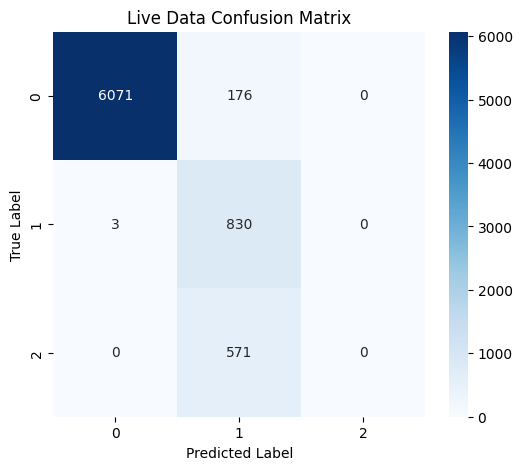


Testing model: /content/mlp_exp2_128_64_32.pth with config {'hidden_sizes': (128, 64, 32), 'activation': 'relu', 'p': 0.2}

=== Live Data Evaluation Metrics ===
Accuracy: 0.9099
Precision: 0.8752
Recall: 0.9099
F1 Score: 0.8855
AUC: nan

Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      0.98      0.99      6247
         1.0       0.55      0.99      0.71       833
         3.0       0.00      0.00      0.00       571

    accuracy                           0.91      7651
   macro avg       0.52      0.66      0.57      7651
weighted avg       0.88      0.91      0.89      7651



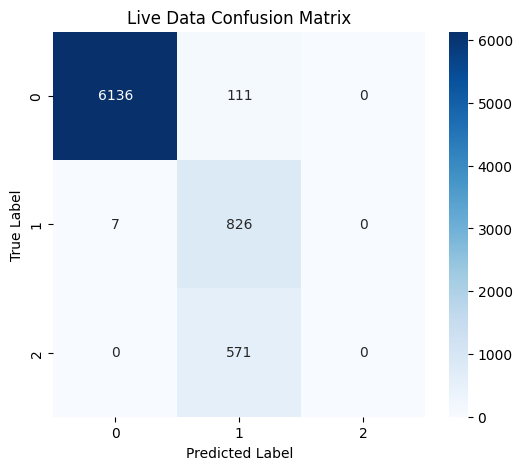


Testing model: /content/mlp_exp2_256_128_64.pth with config {'hidden_sizes': (256, 128, 64), 'activation': 'relu', 'p': 0.2}

=== Live Data Evaluation Metrics ===
Accuracy: 0.9157
Precision: 0.8766
Recall: 0.9157
F1 Score: 0.8899
AUC: nan

Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99      6247
         1.0       0.56      0.99      0.72       833
         3.0       0.00      0.00      0.00       571

    accuracy                           0.92      7651
   macro avg       0.52      0.66      0.57      7651
weighted avg       0.88      0.92      0.89      7651



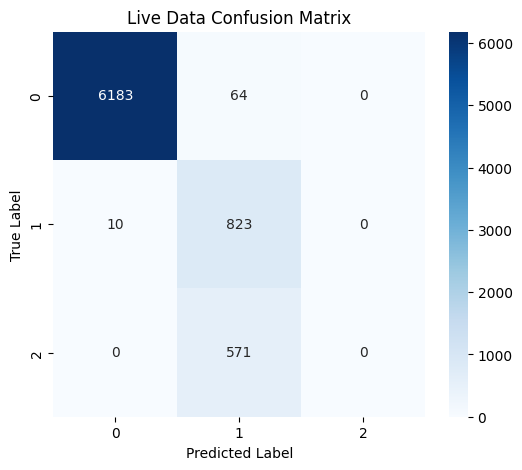


Testing model: /content/mlp_exp3_relu.pth with config {'hidden_sizes': (128, 64, 32), 'activation': 'relu', 'p': 0.2}

=== Live Data Evaluation Metrics ===
Accuracy: 0.9102
Precision: 0.8754
Recall: 0.9102
F1 Score: 0.8858
AUC: nan

Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      0.98      0.99      6247
         1.0       0.55      0.99      0.71       833
         3.0       0.00      0.00      0.00       571

    accuracy                           0.91      7651
   macro avg       0.52      0.66      0.57      7651
weighted avg       0.88      0.91      0.89      7651



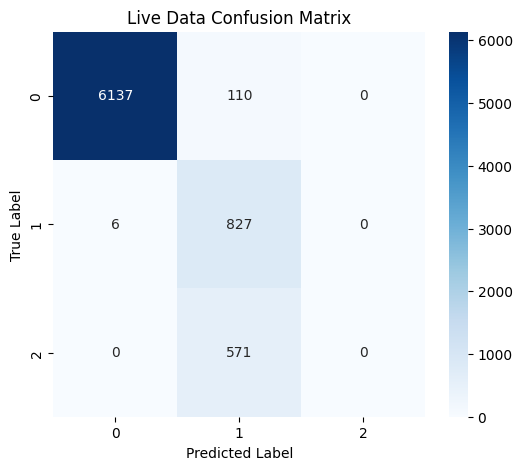


Testing model: /content/mlp_exp3_tanh.pth with config {'hidden_sizes': (128, 64, 32), 'activation': 'tanh', 'p': 0.2}

=== Live Data Evaluation Metrics ===
Accuracy: 0.9169
Precision: 0.8775
Recall: 0.9169
F1 Score: 0.8909
AUC: nan

Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99      6247
         1.0       0.57      0.99      0.72       833
         3.0       0.00      0.00      0.00       571

    accuracy                           0.92      7651
   macro avg       0.52      0.66      0.57      7651
weighted avg       0.88      0.92      0.89      7651



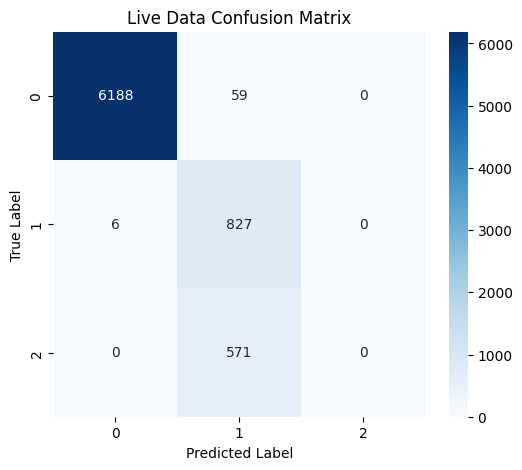


Testing model: /content/mlp_exp3_sigmoid.pth with config {'hidden_sizes': (128, 64, 32), 'activation': 'sigmoid', 'p': 0.2}

=== Live Data Evaluation Metrics ===
Accuracy: 0.9056
Precision: 0.8739
Recall: 0.9056
F1 Score: 0.8823
AUC: nan

Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      0.98      0.99      6247
         1.0       0.54      0.99      0.70       833
         3.0       0.00      0.00      0.00       571

    accuracy                           0.91      7651
   macro avg       0.51      0.66      0.56      7651
weighted avg       0.87      0.91      0.88      7651



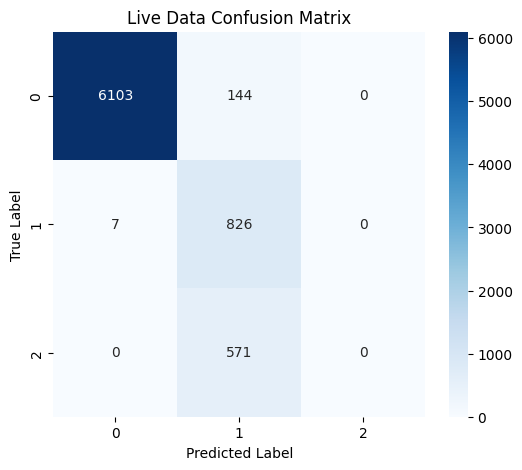

In [ ]:
# Example usage:
# Assuming 'scaler' and 'device' are available from previous cells
# Replace '/content/live_data.csv' with the actual path to your live data file

live_data_path = '/content/test_classification.csv' # <== REPLACE WITH YOUR LIVE DATA PATH

# List of saved model paths and configurations from the experiments
model_configs = [
    {"path": res1["saved_model"], "config": res1["model_config"]}, # Experiment 1 Baseline
] + [{"path": r["saved_model"], "config": r["model_config"]} for r in exp2_results] + [{"path": r["saved_model"], "config": r["model_config"]} for r in exp3_results]

# Test each model
for model_info in model_configs:
    model_path = model_info["path"]
    model_config = model_info["config"]
    print(f"\nTesting model: {model_path} with config {model_config}")
    try:
        test_model_with_live_data(model_path, live_data_path, scaler, device, model_config)
    except FileNotFoundError:
        print(f"Live data file not found at {live_data_path}. Please upload the file or update the path.")
    except AssertionError as e:
        print(f"Error testing model: {e}")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")